# Sberbank Russian Housing Market
By Junbo

## Project description
This is a assignment for UCL course "Big Data in Quantitative Finance".  
This project only uses the training dataset from Kaggle competition "Sberbank Russian Housing Market".  
The goal of the project is not specified in the assignment but it is obvious that the target is to predict the house price(price_doc).  
*The result of the model in the project is not comparable to those in the Kaggle competition becaues of the lack of dataset and limit of time given.*

## Content:
1. EDA (Done in another notebook)
2. Data Clearning
3. Feature Engineering
4. Machine Learning models
5. Model Ensemble

# Import packages and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor
import lightgbm as lgb

from sklearn.model_selection import learning_curve
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('train.csv')
data = data.drop(['id'],axis=1)

In [3]:
data.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


# 1. EDA (Done in another notebook)

# 2. Data clearning

## 2.1 Deal with missing data

In [4]:
count_df = pd.DataFrame(data.count(),columns=['count'])
count_df[count_df['count'] != len(data)]

,count
life_sq,24088
floor,30304
max_floor,20899
material,20899
build_year,16866
num_room,20899
kitch_sq,20899
state,16912
preschool_quota,23783
school_quota,23786


### 2.1.1 Exclude features with too many missing values

In [5]:
count_df[count_df['count'] < 20000].index

Index(['build_year', 'state', 'hospital_beds_raion',
       'cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg',
       'cafe_avg_price_500'],
      dtype='object')

In [6]:
data = data.drop(count_df[count_df['count'] < 20000].index,axis=1)

### 2.1.2 Fill missing values

In [7]:
text_features = []
for x in data.columns:
    if data[x].dtype == object: text_features.append(x)
        
text_features

['timestamp',
 'product_type',
 'sub_area',
 'culture_objects_top_25',
 'thermal_power_plant_raion',
 'incineration_raion',
 'oil_chemistry_raion',
 'radiation_raion',
 'railroad_terminal_raion',
 'big_market_raion',
 'nuclear_reactor_raion',
 'detention_facility_raion',
 'water_1line',
 'big_road1_1line',
 'railroad_1line',
 'ecology']

In [8]:
for x in data.columns.drop(text_features):
    data[x] = data[x].fillna(data[x].mean())

## 2.2 Outliers in average prices

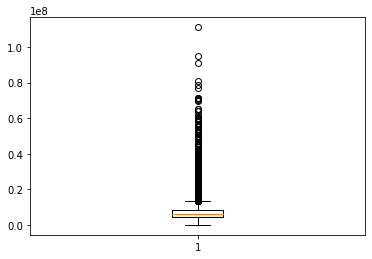

In [9]:
plt.boxplot(data['price_doc'])
plt.show()

In [10]:
data['price_doc'].describe()

count    3.047100e+04
mean     7.123035e+06
std      4.780111e+06
min      1.000000e+05
25%      4.740002e+06
50%      6.274411e+06
75%      8.300000e+06
max      1.111111e+08
Name: price_doc, dtype: float64

In [11]:
data = data[data['price_doc'] < 80000000]

# 3. Feature Engineering

## 3.1 Build new features

### 3.1.1 Time

In [12]:
data['timestamp_year'] = data['timestamp'].apply(lambda x: re.findall(r'([0-9]{4})',x)[0])
data['timestamp_month'] = data['timestamp'].apply(lambda x: re.findall(r'-([0-9]{2})-',x)[0])
data['timestamp_day'] = data['timestamp'].apply(lambda x: re.findall(r'[0-9]{2}\Z',x)[0])

In [13]:
data['timestamp'] = data['timestamp'].apply(lambda x:  datetime.timestamp(datetime.strptime(x,'%Y-%m-%d')))

### 3.1.2 Floor ratio

In [14]:
data = data[data['max_floor'] != 0]
data['floor_ratio'] = data['floor']/data['max_floor'].astype(float)

### 3.1.3 Area ratio

In [15]:
data = data[data['full_sq'] != 0]
data['kitch_ratio'] = data['kitch_sq']/data['full_sq'].astype(float)
data['life_ratio'] = data['life_sq']/data['full_sq'].astype(float)

### 3.1.4 Average sq per room

In [16]:
data = data[data['num_room'] != 0]
data['sq_per_room'] = data['life_sq']/data['num_room'].astype(float)

## 3.2 Feature transfoming

In [17]:
text_features = []
for x in data.columns:
    if data[x].dtype == object: text_features.append(x)
for x in text_features:
    data[x] = LabelEncoder().fit_transform(data[x])

## 3.3 Deal with outliers
In the EDA, full_sq and life_sq are found to be extremely related to the target(price_doc). Hence, first use three sigma rule to delete outliers in these two features.

{'whiskers': [<matplotlib.lines.Line2D at 0x2371f806b88>,
 'caps': [<matplotlib.lines.Line2D at 0x2371f806048>,
 'boxes': [<matplotlib.lines.Line2D at 0x2371f807488>],
 'medians': [<matplotlib.lines.Line2D at 0x2371f805188>],
 'fliers': [<matplotlib.lines.Line2D at 0x2371f805088>],
 'means': []}

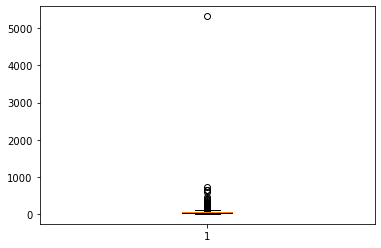

In [18]:
plt.boxplot(data['full_sq'])

{'whiskers': [<matplotlib.lines.Line2D at 0x2371f807848>,
 'caps': [<matplotlib.lines.Line2D at 0x2371f7ec448>,
 'boxes': [<matplotlib.lines.Line2D at 0x2371f7edd48>],
 'medians': [<matplotlib.lines.Line2D at 0x2371f7eb448>],
 'fliers': [<matplotlib.lines.Line2D at 0x2371f7eb348>],
 'means': []}

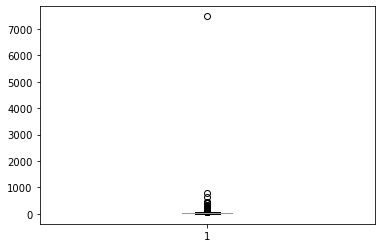

In [19]:
plt.boxplot(data['life_sq'])

In [20]:
def three_sigma(df_col):
    rule = (df_col.mean() - 3 * df_col.std() > df_col) | (df_col.mean() + 3 * df_col.std() < df_col)
    index = np.arange(df_col.shape[0])[rule]
    outrange = df_col.iloc[index]
    return outrange

In [21]:
data = data.drop(three_sigma(data['full_sq']).index)
data = data.drop(three_sigma(data['life_sq']).index)

In [22]:
# Check outliers using Local Outlier factor
lof = LocalOutlierFactor(contamination=0.05)
outlier = lof.fit_predict(data)

In [23]:
# outlier: -1, non_outlier:1
sum(outlier == 1)

28331

In [24]:
data = data[outlier == 1]

## 3.4 Choose most relevant features

In [25]:
all_features = data.columns
all_features = all_features.drop(['price_doc'])

In [26]:
all_corr = []
for x in all_features:
    all_corr.append(np.corrcoef(data['price_doc'],data[x])[0,1])

In [27]:
corr = pd.Series(np.absolute(all_corr),index=all_features).dropna().sort_values().to_frame()
corr.columns = ['corrcoef']
corr

,corrcoef
build_count_1971-1995,0.000093
prom_part_500,0.001110
build_count_foam,0.002418
cafe_sum_3000_min_price_avg,0.002606
trc_sqm_500,0.003674
...,...
trc_count_5000,0.311731
sport_count_5000,0.317406
life_sq,0.410268
num_room,0.421749


In [28]:
corr = pd.Series(np.absolute(all_corr),index=all_features).dropna().sort_values(ascending=False)
corr

full_sq                        0.599633
num_room                       0.421749
life_sq                        0.410268
sport_count_5000               0.317406
trc_count_5000                 0.311731
                                 ...   
trc_sqm_500                    0.003674
cafe_sum_3000_min_price_avg    0.002606
build_count_foam               0.002418
prom_part_500                  0.001110
build_count_1971-1995          0.000093
Length: 291, dtype: float64

Manully choose features with highest correlation coefficients

In [29]:
corr.index[:50]

Index(['full_sq', 'num_room', 'life_sq', 'sport_count_5000', 'trc_count_5000',
       'zd_vokzaly_avto_km', 'sport_count_3000', 'sadovoe_km',
       'bulvar_ring_km', 'kremlin_km', 'sport_count_2000', 'ttk_km',
       'trc_sqm_5000', 'office_sqm_5000', 'sport_count_1500',
       'nuclear_reactor_km', 'sport_objects_raion', 'trc_count_3000',
       'stadium_km', 'cafe_count_5000_price_1000', 'detention_facility_km',
       'basketball_km', 'office_km', 'trc_sqm_3000', 'office_sqm_3000',
       'cafe_count_5000_price_1500', 'cafe_count_5000',
       'cafe_count_5000_na_price', 'cafe_count_5000_price_500',
       'university_km', 'catering_km', 'office_sqm_2000',
       'cafe_count_5000_price_2500', 'swim_pool_km', 'workplaces_km',
       'theater_km', 'office_count_5000', 'thermal_power_plant_km',
       'exhibition_km', 'cafe_count_5000_price_high', 'church_count_5000',
       'sport_count_1000', 'school_education_centers_raion',
       'market_count_5000', 'cafe_count_5000_price_4000',

In [30]:
features_choosen = corr.index[:50]

## 3.5 A quick demo/check
### 3.5.1 Linear regression and learning curve

In [31]:
X_train, X_test, y_train, y_test = train_test_split(data[features_choosen], data['price_doc'], test_size=0.2, random_state = 4)
X_train_intercept = sm.add_constant(X_train)
LR = sm.OLS(y_train,X_train_intercept).fit()

In [32]:
print(LR.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     607.5
Date:                Sat, 18 Jan 2020   Prob (F-statistic):               0.00
Time:                        21:47:48   Log-Likelihood:            -3.6793e+05
No. Observations:               22664   AIC:                         7.360e+05
Df Residuals:                   22614   BIC:                         7.364e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [33]:
X_test_intercept = sm.add_constant(X_test)
y_predict_LR = LR.predict(X_test_intercept)

In [34]:
r2_score(y_train,LR.predict(X_train_intercept))

0.5682735562678369

In [35]:
r2_score(y_test,y_predict_LR)

0.553262118132723

In [36]:
# Define error: Root Mean Squared Logarithmic Error
def rmsle(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))

In [37]:
rmsle(y_train,LR.predict(X_train_intercept))

0.5051577668177394

In [38]:
rmsle(y_test,y_predict_LR)

0.5086367409658532

Text(0, 0.5, 'Predicted')

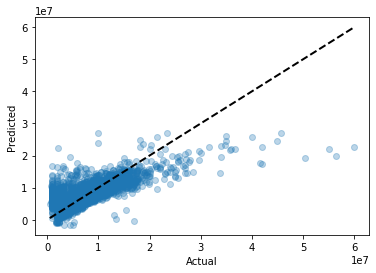

In [39]:
plt.scatter(y_test,y_predict_LR,alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')

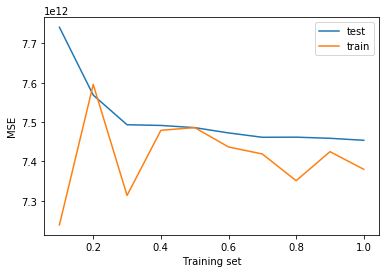

In [40]:
LR = LinearRegression()
learn_curve = learning_curve(LR,X_train,y_train, train_sizes=np.arange(0.1,1.1,0.1), cv=5, scoring = 'neg_mean_squared_error', n_jobs = -1)
plt.plot(np.arange(0.1,1.1,0.1),-learn_curve[2].mean(axis=1),label='test')
plt.plot(np.arange(0.1,1.1,0.1),-learn_curve[1].mean(axis=1),label='train')
plt.ylabel('MSE')
plt.xlabel('Training set')
plt.legend()

Analysis:
 1. "High bias, low variance" means under-fitting
 2. Two lines converges, so there is no need to collect more data   

Solution: use more features and build more complex models

### 3.5.2 "Feature" curve

In [41]:
num_features = [50,100,150,200,250,300,350]
train_r2= []
test_r2 = []
for num in num_features:
    features_choosen = corr.index[:num]
    X_train, X_test, y_train, y_test = train_test_split(data[features_choosen], data['price_doc'], test_size=0.2)
    LR = LinearRegression(fit_intercept=True,normalize=False,copy_X=True,n_jobs=-1)
    y_predict_LR = LR.fit(X_train, y_train).predict(X_test)
    train_r2.append(r2_score(y_train,LR.predict(X_train)))
    test_r2.append(r2_score(y_test,LR.predict(X_test)))

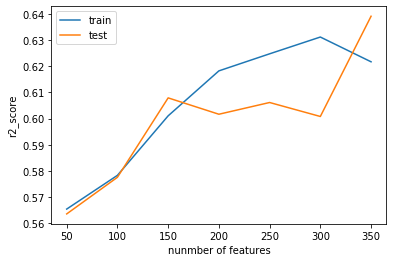

In [42]:
plt.plot(num_features, train_r2,label='train')
plt.plot(num_features, test_r2,label='test')
plt.xlabel('nunmber of features')
plt.ylabel('r2_score')
plt.legend()

Analysis:
1. R2 increases as the number of features increases, this means that more features is helpful.
2. However, as the model becomes more complex, it may also overfit the data.  

Solution: PCA

## 3.6 Data Standardisation

In [43]:
train_data = data.drop(['price_doc'],axis=1)

In [44]:
scaler = StandardScaler().fit(train_data)
train_data = scaler.transform(train_data)

## 3.7 PCA

In [45]:
pca = PCA(n_components=40)
train_pca = pca.fit_transform(train_data)

In [46]:
sum(pca.explained_variance_ratio_)

0.8853844734265918

Text(0, 0.5, 'explained variance ratio')

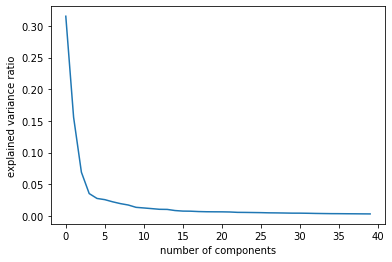

In [47]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('explained variance ratio')

# 4. Machine Learning models

## 4.1 Train test split

In [48]:
X_train, X_test, y_train, y_test = train_test_split(train_pca, data['price_doc'], test_size=0.2)

## 4.2 Linear Regression

In [49]:
LR = LinearRegression(fit_intercept=True,normalize=False,copy_X=True,n_jobs=-1)

In [50]:
y_predict_LR = LR.fit(X_train, y_train).predict(X_test)

In [51]:
r2_score(y_train,LR.predict(X_train))

0.5458573666976778

In [52]:
r2_score(y_test,y_predict_LR)

0.5468692256552631

In [53]:
rmsle(y_train,LR.predict(X_train))

0.5041988726550296

In [54]:
rmsle(y_test,y_predict_LR)

0.5062717240338102

It is a little overfitting, but is acceptable

Text(0, 0.5, 'Predicted')

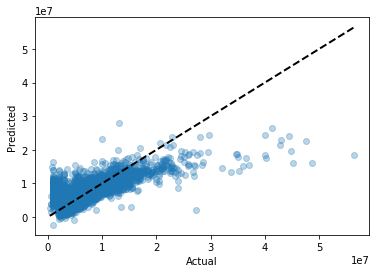

In [55]:
plt.scatter(y_test,y_predict_LR,alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')

## 4.3 Ridge regression
Use Leave-One-Out cross-validation to adjust parameters

In [56]:
ridge = RidgeCV(alphas = (0.01,0.1,1,10,100), fit_intercept=True, store_cv_values= True)
ridge.fit(X_train,y_train)

RidgeCV(alphas=array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]), cv=None,
        fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=True)

In [57]:
ridge.alpha_

100.0

In [58]:
ridge.score(X_train,y_train)

0.54585578895641

In [59]:
ridge.score(X_test,y_test)

0.5468291168570849

In [60]:
rmsle(y_train,ridge.predict(X_train))

0.5036720900725103

In [61]:
rmsle(y_test,ridge.predict(X_test))

0.5059585413813269

In [62]:
y_predict_ridge = ridge.predict(X_test)

Text(0, 0.5, 'Predicted')

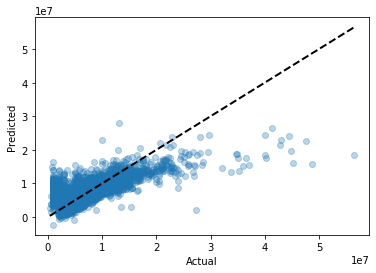

In [63]:
plt.scatter(y_test,y_predict_ridge,alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')

## 4.4 Lasso regression
Use 5-fold cross-validation to adjust parameters

In [64]:
lasso = LassoCV(alphas = (0.001,0.01,0.1,1,10,100), fit_intercept=True, cv = 10, max_iter=10000)
lasso.fit(X_train,y_train)

LassoCV(alphas=(0.001, 0.01, 0.1, 1, 10, 100), copy_X=True, cv=10, eps=0.001,
        fit_intercept=True, max_iter=10000, n_alphas=100, n_jobs=None,
        normalize=False, positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [65]:
lasso.alpha_

100.0

In [66]:
lasso.score(X_train,y_train)

0.5458573543207041

In [67]:
lasso.score(X_test,y_test)

0.5468603156138787

In [68]:
rmsle(y_train,lasso.predict(X_train))

0.5040853392902598

In [69]:
rmsle(y_test,lasso.predict(X_test))

0.5062560902337621

In [70]:
y_predict_lasso = lasso.predict(X_test)

Text(0, 0.5, 'Predicted')

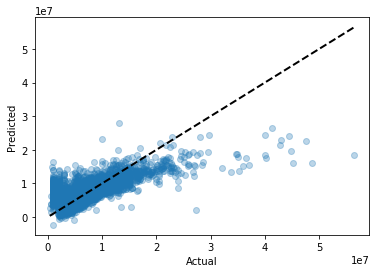

In [71]:
plt.scatter(y_test,y_predict_lasso,alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')

## 4.5 Generalised linear regression
Use GLM with Gamma distribution

In [72]:
X_train_intercept = sm.add_constant(X_train)
X_test_intercept = sm.add_constant(X_test)
glm = sm.GLM(y_train,X_train_intercept, family=sm.families.Gamma(link = sm.families.links.log()))
glm_fitted = glm.fit()

In [73]:
print(glm_fitted.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              price_doc   No. Observations:                22664
Model:                            GLM   Df Residuals:                    22623
Model Family:                   Gamma   Df Model:                           40
Link Function:                    log   Scale:                         0.10022
Method:                          IRLS   Log-Likelihood:            -3.6681e+05
Date:                Sat, 18 Jan 2020   Deviance:                       3614.0
Time:                        21:47:59   Pearson chi2:                 2.27e+03
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.6906      0.002   7460.171      0.0

In [74]:
y_train_predict_glm = glm_fitted.predict(X_train_intercept)

Text(0, 0.5, 'Predicted')

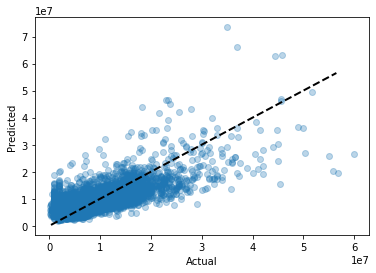

In [75]:
plt.scatter(y_train,y_train_predict_glm,alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [76]:
y_predict_glm = glm_fitted.predict(X_test_intercept)

In [77]:
r2_score(y_test,y_predict_glm)

0.5387658891520046

Text(0, 0.5, 'Predicted')

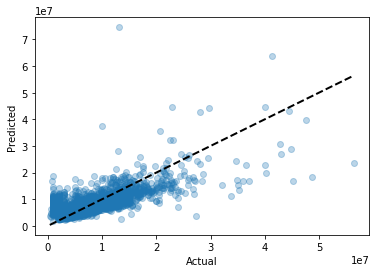

In [78]:
plt.scatter(y_test,y_predict_glm,alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')

## 4.6 Xgboost Regression

In [79]:
xgb = XGBRegressor()
param_grid = {'n_estimators': [100,200,300, 400]}
xgb_cv = GridSearchCV(xgb,param_grid = param_grid, cv = 5, n_jobs=-1,return_train_score=True)
xgb_cv.fit(X_train,y_train)

[21:48:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'n_estimators': [100, 200, 300, 400]},
             pre_dispatch='2*n_jobs', refit=True, return_tra

In [80]:
xgb_cv.best_params_

{'n_estimators': 400}

In [81]:
xgb_cv.best_score_

0.6304128529446752

In [82]:
xgb_cv.cv_results_

{'mean_fit_time': array([ 7.09981089, 14.28519435, 21.47242532, 23.15192823]),
 'std_fit_time': array([0.07112443, 0.27259421, 0.35503467, 2.35458802]),
 'mean_score_time': array([0.02214127, 0.03570452, 0.0522603 , 0.05784717]),
 'std_score_time': array([0.00502238, 0.00097712, 0.00241018, 0.00621005]),
 'param_n_estimators': masked_array(data=[100, 200, 300, 400],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 100},
  {'n_estimators': 200},
  {'n_estimators': 300},
  {'n_estimators': 400}],
 'split0_test_score': array([0.60121179, 0.62681155, 0.63597013, 0.63991702]),
 'split1_test_score': array([0.59289043, 0.61818201, 0.62690425, 0.63181774]),
 'split2_test_score': array([0.60024877, 0.62177418, 0.62991185, 0.63449437]),
 'split3_test_score': array([0.56093409, 0.5893792 , 0.60181269, 0.60557776]),
 'split4_test_score': array([0.59833369, 0.62447929, 0.63422574, 0.64025955]),
 'mean_test_score': arra

No clear improvment after n_estimators reaches 200

In [83]:
xgb = XGBRegressor(n_estimators = 200)
param_grid = {'max_depth': [3, 4, 5, 6]}
xgb_cv = GridSearchCV(xgb,param_grid = param_grid, cv = 5, n_jobs=-1,return_train_score=True)
xgb_cv.fit(X_train,y_train)

[21:50:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=200, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=-1, param_grid={'max_depth': [3, 4, 5, 6]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
         

In [84]:
xgb_cv.best_params_

{'max_depth': 6}

In [85]:
xgb_cv.best_score_

0.6481259466465531

In [86]:
xgb_cv.cv_results_

{'mean_fit_time': array([14.46351137, 19.80483198, 25.63264723, 22.47509937]),
 'std_fit_time': array([0.11977487, 0.50912009, 0.43478081, 3.28815078]),
 'mean_score_time': array([0.03690152, 0.04807181, 0.06023922, 0.06003942]),
 'std_score_time': array([0.00089196, 0.00146573, 0.00241024, 0.00494693]),
 'param_max_depth': masked_array(data=[3, 4, 5, 6],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 3},
  {'max_depth': 4},
  {'max_depth': 5},
  {'max_depth': 6}],
 'split0_test_score': array([0.62681155, 0.64377846, 0.64996521, 0.66224872]),
 'split1_test_score': array([0.61818201, 0.63996887, 0.64911015, 0.65222413]),
 'split2_test_score': array([0.62177418, 0.63854702, 0.65046447, 0.64974782]),
 'split3_test_score': array([0.5893792 , 0.61726854, 0.63342357, 0.62740318]),
 'split4_test_score': array([0.62447929, 0.63556594, 0.64640816, 0.64900608]),
 'mean_test_score': array([0.61612488, 0.63502574, 0.64

No clear improvement after max_depth reaches 4

In [87]:
xgb = XGBRegressor(n_estimators = 200, max_depth = 4)
param_grid = {'gamma': [0.01, 0.1, 1]}
xgb_cv = GridSearchCV(xgb,param_grid = param_grid, cv = 5, n_jobs=-1, return_train_score=True)
xgb_cv.fit(X_train,y_train)

[21:51:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=4,
                                    min_child_weight=1, missing=None,
                                    n_estimators=200, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=-1, param_grid={'gamma': [0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
           

In [88]:
xgb_cv.best_params_

{'gamma': 0.01}

In [89]:
xgb_cv.best_score_

0.6350257433342493

In [90]:
xgb_cv.cv_results_

{'mean_fit_time': array([20.23847022, 19.52657681, 17.49421296]),
 'std_fit_time': array([0.55051267, 1.49855322, 0.14802433]),
 'mean_score_time': array([0.0486702 , 0.05006728, 0.03790336]),
 'std_score_time': array([0.00255508, 0.00146759, 0.00427391]),
 'param_gamma': masked_array(data=[0.01, 0.1, 1],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'gamma': 0.01}, {'gamma': 0.1}, {'gamma': 1}],
 'split0_test_score': array([0.64377846, 0.64377846, 0.64377846]),
 'split1_test_score': array([0.63996887, 0.63996887, 0.63996887]),
 'split2_test_score': array([0.63854702, 0.63854702, 0.63854702]),
 'split3_test_score': array([0.61726854, 0.61726854, 0.61726854]),
 'split4_test_score': array([0.63556594, 0.63556594, 0.63556594]),
 'mean_test_score': array([0.63502574, 0.63502574, 0.63502574]),
 'std_test_score': array([0.00926361, 0.00926361, 0.00926361]),
 'rank_test_score': array([1, 1, 1]),
 'split0_train_score': array([0.76362

In [91]:
xgb = XGBRegressor(n_estimators = 200, max_depth = 4, gamma = 0.01)
param_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.2]}
xgb_cv = GridSearchCV(xgb,param_grid = param_grid, cv = 5, n_jobs=-1, return_train_score=True)
xgb_cv.fit(X_train,y_train)

[21:52:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0.01,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=4,
                                    min_child_weight=1, missing=None,
                                    n_estimators=200, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2]},
             pre_dispatch='2*n_jobs', refit=True, retu

In [92]:
xgb_cv.best_params_

{'learning_rate': 0.1}

In [93]:
xgb_cv.best_score_

0.6350257433342493

In [94]:
xgb_cv.cv_results_

{'mean_fit_time': array([19.21620646, 19.93907213, 19.94266376, 13.6855988 ]),
 'std_fit_time': array([0.07813228, 0.13244703, 0.21749369, 3.13483441]),
 'mean_score_time': array([0.04527917, 0.04986696, 0.0460773 , 0.03550501]),
 'std_score_time': array([0.00173873, 0.00154511, 0.00212985, 0.00406836]),
 'param_learning_rate': masked_array(data=[0.01, 0.05, 0.1, 0.2],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.01},
  {'learning_rate': 0.05},
  {'learning_rate': 0.1},
  {'learning_rate': 0.2}],
 'split0_test_score': array([0.46276611, 0.62671685, 0.64377846, 0.63488903]),
 'split1_test_score': array([0.43814745, 0.6264769 , 0.63996887, 0.62524706]),
 'split2_test_score': array([0.44817741, 0.62882589, 0.63854702, 0.64129252]),
 'split3_test_score': array([0.42792035, 0.60560226, 0.61726854, 0.62217869]),
 'split4_test_score': array([0.44212923, 0.62406708, 0.63556594, 0.63558908]),
 'mean_test_sco

In [95]:
xgb_cv.score(X_train,y_train)

0.7532713052192793

Strong evidence of overfitting

In [96]:
xgb = XGBRegressor(n_estimators = 200, max_depth = 4, gamma = 0.01, learning_rate= 0.1)
param_grid = {'early_stopping_rounds': [1,2,3,5]}
xgb_cv = GridSearchCV(xgb,param_grid = param_grid, cv = 5, n_jobs=-1, return_train_score=True)
xgb_cv.fit(X_train,y_train)

[21:53:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0.01,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=4,
                                    min_child_weight=1, missing=None,
                                    n_estimators=200, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'early_stopping_rounds': [1, 2, 3, 5]},
             pre_dispatch='2*n_jobs', refit=True, return

In [97]:
xgb_cv.best_params_

{'early_stopping_rounds': 1}

In [98]:
xgb_cv.best_score_

0.6350257433342493

In [99]:
xgb_cv.cv_results_

{'mean_fit_time': array([19.74419379, 19.68993945, 19.70131068, 13.21745825]),
 'std_fit_time': array([0.25148313, 0.14215799, 0.18967342, 3.29367041]),
 'mean_score_time': array([0.05086441, 0.04966731, 0.04926867, 0.03789153]),
 'std_score_time': array([0.00252287, 0.00222115, 0.00499065, 0.00227146]),
 'param_early_stopping_rounds': masked_array(data=[1, 2, 3, 5],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'early_stopping_rounds': 1},
  {'early_stopping_rounds': 2},
  {'early_stopping_rounds': 3},
  {'early_stopping_rounds': 5}],
 'split0_test_score': array([0.64377846, 0.64377846, 0.64377846, 0.64377846]),
 'split1_test_score': array([0.63996887, 0.63996887, 0.63996887, 0.63996887]),
 'split2_test_score': array([0.63854702, 0.63854702, 0.63854702, 0.63854702]),
 'split3_test_score': array([0.61726854, 0.61726854, 0.61726854, 0.61726854]),
 'split4_test_score': array([0.63556594, 0.63556594, 0.63556594, 0.6355659

In [100]:
xgb_cv.score(X_train,y_train)

0.7532713052192793

Hard to solve the overfitting problem, try reduce n_compenents

In [101]:
xgb = XGBRegressor(max_depth = 4, gamma = 0.01, learning_rate= 0.1)
param_grid = {'n_estimators': [50,100,150]}
xgb_cv = GridSearchCV(xgb,param_grid = param_grid, cv = 5, n_jobs=-1, return_train_score=True)
xgb_cv.fit(X_train,y_train)

[21:53:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0.01,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=4,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=-1, param_grid={'n_estimators': [50, 100, 150]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
 

In [102]:
xgb_cv.best_params_

{'n_estimators': 150}

In [103]:
xgb_cv.best_score_

0.6299414433717764

In [104]:
xgb_cv.cv_results_

{'mean_fit_time': array([ 5.28107343,  9.98948259, 12.19359903]),
 'std_fit_time': array([0.18173397, 0.33679865, 1.14564148]),
 'mean_score_time': array([0.01496005, 0.02433524, 0.02752318]),
 'std_score_time': array([0.00302513, 0.00101699, 0.00232155]),
 'param_n_estimators': masked_array(data=[50, 100, 150],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 50},
  {'n_estimators': 100},
  {'n_estimators': 150}],
 'split0_test_score': array([0.59253163, 0.62570745, 0.63809019]),
 'split1_test_score': array([0.5873232 , 0.62282052, 0.63471255]),
 'split2_test_score': array([0.59760431, 0.62835883, 0.63432723]),
 'split3_test_score': array([0.57235639, 0.60111471, 0.61090954]),
 'split4_test_score': array([0.59555015, 0.62287729, 0.63166809]),
 'mean_test_score': array([0.58907285, 0.62017564, 0.62994144]),
 'std_test_score': array([0.00904671, 0.00974883, 0.00973258]),
 'rank_test_score': array([3, 2, 1]),
 'spl

In [105]:
xgb_cv.score(X_train,y_train)

0.7348117326018321

Choose n_estimators = 100

In [106]:
xgb = XGBRegressor(n_estimators = 100, max_depth = 4, gamma = 0.01, learning_rate= 0.1).fit(X_train,y_train)

[21:53:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [107]:
xgb.score(X_train,y_train)

0.7093633818173432

In [108]:
xgb.score(X_test,y_test)

0.6231697974171969

In [109]:
rmsle(y_train,xgb.predict(X_train))

0.45479187683581057

In [110]:
rmsle(y_test,xgb.predict(X_test))

0.47430591972363223

Text(0, 0.5, 'Predicted')

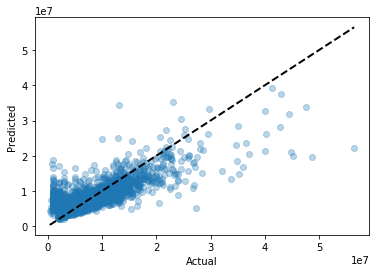

In [111]:
y_predict_xgb = xgb.predict(X_test)
plt.scatter(y_test,y_predict_xgb,alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')

## 4.7 Light GBM 

In [112]:
lgbm = lgb.LGBMRegressor(num_thread = 4, metric = 'l2')
param_grid = {'n_estimators':[50,75,100,150]}
lgbm_cv = GridSearchCV(lgbm,param_grid= param_grid, cv = 5, return_train_score=True)
lgbm_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, metric='l2',
                                     min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     num_thread=4, objective=None,
                                     random_state=None, reg_alpha=0.0,
                                     reg_lambda=0.0, silent=True, subsample=1.0,
                                     subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'n_estimators': [50, 75, 100, 150]},
       

In [113]:
lgbm_cv.best_params_

{'n_estimators': 150}

In [114]:
lgbm_cv.best_score_

0.6541118694885167

In [115]:
lgbm_cv.cv_results_

{'mean_fit_time': array([0.27985101, 0.37459865, 0.42865529, 0.69035358]),
 'std_fit_time': array([0.02451527, 0.02726615, 0.00820813, 0.08072457]),
 'mean_score_time': array([0.00718093, 0.01116934, 0.01056995, 0.01555891]),
 'std_score_time': array([0.00171604, 0.0046532 , 0.00324976, 0.00870827]),
 'param_n_estimators': masked_array(data=[50, 75, 100, 150],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 50},
  {'n_estimators': 75},
  {'n_estimators': 100},
  {'n_estimators': 150}],
 'split0_test_score': array([0.64488787, 0.65781983, 0.66230235, 0.66549278]),
 'split1_test_score': array([0.63455907, 0.64634982, 0.65166214, 0.65579492]),
 'split2_test_score': array([0.63398543, 0.64092606, 0.6448364 , 0.64974776]),
 'split3_test_score': array([0.62840031, 0.64169983, 0.64721434, 0.65195343]),
 'split4_test_score': array([0.63047736, 0.63846722, 0.64396763, 0.64756902]),
 'mean_test_score': array([0.634

Choose n_estimators = 75 as the test score increase little after n_estimators reaches 75

In [116]:
lgbm = lgb.LGBMRegressor(num_thread = 4, metric = 'l2',n_estimators = 75)
param_grid = {'max_depth':[4,5,6,7],'num_leaves':[50,100,150]}
lgbm_cv = GridSearchCV(lgbm,param_grid= param_grid, cv = 5, return_train_score=True)
lgbm_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, metric='l2',
                                     min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=75, n_jobs=-1, num_leaves=31,
                                     num_thread=4, objective=None,
                                     random_state=None, reg_alpha=0.0,
                                     reg_lambda=0.0, silent=True, subsample=1.0,
                                     subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [4, 5, 6, 7],
                  

In [117]:
lgbm_cv.best_params_

{'max_depth': 7, 'num_leaves': 150}

In [118]:
lgbm_cv.best_score_

0.6456729580105818

In [119]:
lgbm_cv.score(X_train,y_train)

0.802339912326251

In [120]:
lgbm_cv.cv_results_

{'mean_fit_time': array([0.18370867, 0.16835084, 0.19029083, 0.268681  , 0.25491805,
        0.25691595, 0.35325527, 0.33271046, 0.35146017, 0.45498295,
        0.51043515, 0.4888927 ]),
 'std_fit_time': array([0.01460865, 0.00116261, 0.02503601, 0.0250216 , 0.03242545,
        0.01039851, 0.03639035, 0.01235462, 0.04102704, 0.03571133,
        0.0493067 , 0.0570363 ]),
 'mean_score_time': array([0.00757976, 0.00638213, 0.00777941, 0.01077108, 0.00738039,
        0.00877347, 0.01137018, 0.00857658, 0.00857677, 0.00897603,
        0.01077104, 0.01057167]),
 'std_score_time': array([0.00184967, 0.00048957, 0.00171585, 0.00569095, 0.00079798,
        0.00193661, 0.00299864, 0.00173881, 0.00079794, 0.00063068,
        0.00358987, 0.00371045]),
 'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dtype=object

Choose max_depth = 6, num_leaves = 50

In [121]:
lgbm = lgb.LGBMRegressor(num_thread = 4, metric = 'l2',n_estimators = 75, max_depth = 6, num_leaves = 50)
param_grid = {'learning_rate':[0.01,0.05,0.1]}
lgbm_cv = GridSearchCV(lgbm,param_grid= param_grid, cv = 5, return_train_score=True)
lgbm_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=6, metric='l2',
                                     min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=75, n_jobs=-1, num_leaves=50,
                                     num_thread=4, objective=None,
                                     random_state=None, reg_alpha=0.0,
                                     reg_lambda=0.0, silent=True, subsample=1.0,
                                     subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.01, 0.05, 0.1]},
         

In [122]:
lgbm_cv.best_params_

{'learning_rate': 0.1}

In [123]:
lgbm_cv.best_score_

0.6389986752649587

In [124]:
lgbm_cv.score(X_train,y_train)

0.7636859659336838

In [125]:
lgbm_cv.cv_results_

{'mean_fit_time': array([0.4085073 , 0.38457193, 0.35505037]),
 'std_fit_time': array([0.015827 , 0.0065124, 0.0161312]),
 'mean_score_time': array([0.01037216, 0.00797868, 0.01057172]),
 'std_score_time': array([2.14829153e-03, 6.03156597e-07, 3.06419953e-03]),
 'param_learning_rate': masked_array(data=[0.01, 0.05, 0.1],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.01},
  {'learning_rate': 0.05},
  {'learning_rate': 0.1}],
 'split0_test_score': array([0.41265543, 0.62939798, 0.65279841]),
 'split1_test_score': array([0.39950528, 0.62233301, 0.63637071]),
 'split2_test_score': array([0.41422293, 0.62978527, 0.6477456 ]),
 'split3_test_score': array([0.38441481, 0.60536612, 0.62071298]),
 'split4_test_score': array([0.41482154, 0.61885965, 0.63736531]),
 'mean_test_score': array([0.40512357, 0.62114851, 0.63899868]),
 'std_test_score': array([0.01178139, 0.00892625, 0.01105358]),
 'rank_test_score': array([

Choose learning_rate = 0.1

In [126]:
lgbm = lgb.LGBMRegressor(num_thread = 4, metric = 'l2',n_estimators = 75, max_depth = 6, num_leaves = 50, learning_rate = 0.1).fit(X_train,y_train)
lgbm.score(X_train,y_train)

0.7636859659336838

In [127]:
lgbm.score(X_test,y_test)

0.6462604721336261

In [128]:
rmsle(y_train,lgbm.predict(X_train))

0.43342735739222926

In [129]:
rmsle(y_test,lgbm.predict(X_test))

0.46927323541439503

Text(0, 0.5, 'Predicted')

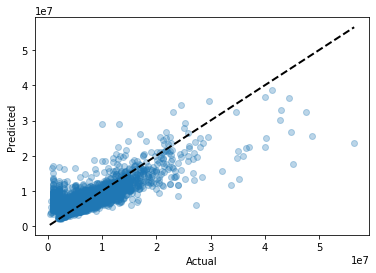

In [130]:
y_predict_lgbm = lgbm.predict(X_test)
plt.scatter(y_test,y_predict_lgbm,alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')

# 5. Model ensemble

In [131]:
y_predict_df = pd.DataFrame([y_predict_LR,y_predict_ridge,y_predict_lasso,y_predict_glm,y_predict_xgb,y_predict_lgbm]).T
y_predict_df.columns = ['LR','Ridge','Lasso','GLM','XGB','LGBM']

In [132]:
y_predict_df

,LR,Ridge,Lasso,GLM,XGB,LGBM
0,6.609587e+06,6.607262e+06,6.609675e+06,6.026427e+06,6238165.00,5.905588e+06
1,3.990810e+06,3.997687e+06,3.991030e+06,4.639670e+06,5464030.50,5.210114e+06
2,3.375829e+06,3.377350e+06,3.375688e+06,3.768139e+06,5749136.50,5.365344e+06
3,8.363433e+06,8.368288e+06,8.363651e+06,7.615716e+06,6531491.00,6.555601e+06
4,9.718638e+06,9.716018e+06,9.718643e+06,9.360229e+06,10250630.00,9.708571e+06
...,...,...,...,...,...,...
5662,3.135273e+06,3.140555e+06,3.135973e+06,3.910284e+06,3968444.25,3.913563e+06
5663,1.216079e+07,1.215854e+07,1.216071e+07,1.111355e+07,10750942.00,9.944764e+06
5664,6.134493e+06,6.135670e+06,6.133912e+06,5.135887e+06,5833087.50,5.376346e+06
5665,4.210560e+06,4.213615e+06,4.211164e+06,4.582304e+06,3991026.50,4.015105e+06


## 5.1 Bagging (Average)

### a. Base on all models

In [133]:
y_predict = y_predict_df.mean(axis=1)

In [134]:
mean_squared_error(y_test,y_predict)

7423604891473.464

In [135]:
print('r2:',r2_score(y_test,y_predict))
print('MSE:',mean_squared_error(y_test,y_predict))
print('RMSLE:',rmsle(y_test,y_predict))

r2: 0.6031540061665903
MSE: 7423604891473.464
RMSLE: 0.7562115202013615


### b. Base on models exclude GLM

In [136]:
y_predict = y_predict_df.drop('GLM',axis=1).mean(axis=1)

In [137]:
print('r2:',r2_score(y_test,y_predict))
print('MSE:',mean_squared_error(y_test,y_predict))
print('RMSLE:',rmsle(y_test,y_predict))

r2: 0.6043155574999199
MSE: 7401876315920.747
RMSLE: 0.7595912256258369


### c. Base on both XGBoost and LightGBM

In [138]:
y_predict = y_predict_df[['XGB','LGBM']].mean(axis=1)
print('r2:',r2_score(y_test,y_predict))
print('MSE:',mean_squared_error(y_test,y_predict))
print('RMSLE:',rmsle(y_test,y_predict))

r2: 0.6409757760931377
MSE: 6716091446475.035
RMSLE: 0.739739294651439


### d. Base only on XGBoost

In [139]:
y_predict = y_predict_df[['XGB']].mean(axis=1)
print('r2:',r2_score(y_test,y_predict))
print('MSE:',mean_squared_error(y_test,y_predict))
print('RMSLE:',rmsle(y_test,y_predict))

r2: 0.6231697974171969
MSE: 7049179224732.098
RMSLE: 0.7371695514754024


### e. Base only on LightGBM

In [140]:
y_predict = y_predict_df[['LGBM']].mean(axis=1)
print('r2:',r2_score(y_test,y_predict))
print('MSE:',mean_squared_error(y_test,y_predict))
print('RMSLE:',rmsle(y_test,y_predict))

r2: 0.6462604721336261
MSE: 6617233209310.647
RMSLE: 0.7437471416105292


## 5.2 Stacking

In [141]:
y_train_predict_LR = LR.predict(X_train)
y_train_predict_ridge = ridge.predict(X_train)
y_train_predict_lasso = lasso.predict(X_train)
y_train_predict_xgb = xgb.predict(X_train)
y_train_predict_lgbm = lgbm.predict(X_train)

y_train_predict_df = pd.DataFrame([y_train_predict_LR,y_train_predict_ridge,y_train_predict_lasso,
                                   y_train_predict_xgb,y_train_predict_lgbm]).T
y_train_predict_df.columns = ['LR','Ridge','Lasso','XGB','LGBM']

In [142]:
y_train_predict = y_train_predict_df.mean(axis=1)

In [143]:
print('r2:',r2_score(y_train,y_train_predict))
print('MSE:',mean_squared_error(y_train,y_train_predict))

r2: 0.6535459261861545
MSE: 5869869870299.294


In [144]:
xgb_stacking = XGBRegressor()
xgb_stacking.fit(y_train_predict_df,y_train)

[21:54:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [145]:
xgb_stacking.score(y_train_predict_df,y_train)

0.7958331795569686

In [146]:
y_predict_df_drop_glm = y_predict_df.drop('GLM',axis=1)
xgb_stacking.score(y_predict_df_drop_glm,y_test)

0.640922760612739

In [147]:
print('r2:',r2_score(y_test,xgb_stacking.predict(y_predict_df_drop_glm)))
print('MSE:',mean_squared_error(y_test,xgb_stacking.predict(y_predict_df_drop_glm)))
print('RMSLE:',rmsle(y_test,xgb_stacking.predict(y_predict_df_drop_glm)))

r2: 0.640922760612739
MSE: 6717083181268.198
RMSLE: 0.4711978816881218


Text(0, 0.5, 'Predicted')

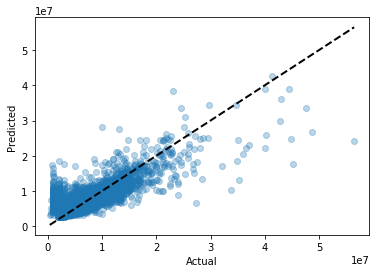

In [148]:
plt.scatter(y_test,xgb_stacking.predict(y_predict_df_drop_glm),alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')

Final Model: Stack models(Linear Regression, Ridge Regression, Lasso Regression, XGBoost, LightGBM) using XGBoost